### IMPORTING NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import IsolationForest
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import shap



### DATA PREPROCESSING


##### Loading the dataset

In [2]:
# Load data
df = pd.read_csv("loan.csv")  

##### Separating the input parameters and the target feature

In [3]:
# Columns to use
features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
            'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'HasMortgage', 'HasDependents']
target = 'Default'

##### Target encoding of categorical variables


In [4]:
# Encode categorical features using Target Encoding
cat_cols = ['HasMortgage', 'HasDependents']
encoder = TargetEncoder()
df[cat_cols] = encoder.fit_transform(df[cat_cols], df[target])

##### Removing anomalies using Isolation Forests


In [5]:
# Detect and remove anomalies using Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
outliers = iso_forest.fit_predict(df[features])
df = df[outliers == 1]  # Keep only non-outliers

##### Splitting Data

In [6]:
# Split data
X = df[features]
y = df[target]

##### Visualizing the class imbalance

C:\Users\aadit\AppData\Local\Temp\ipykernel_18272\1285801426.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


Text(0, 0.5, 'Count')

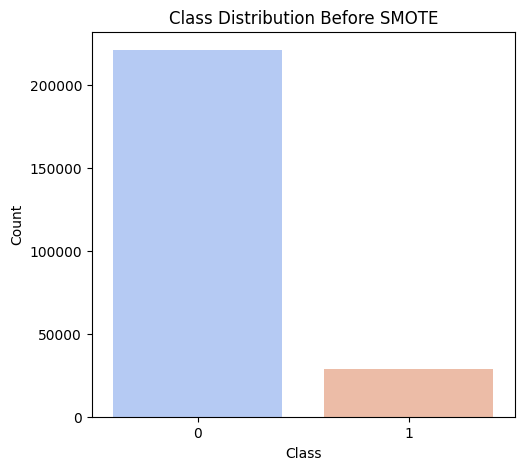

In [7]:
# Required Imports
import matplotlib.pyplot as plt
import seaborn as sns

# %% 
# Visualizing class imbalance before and after SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")

##### Applying Synthetic Minority Over Sampling

In [8]:
# Handle class imbalance with SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

##### Visualizing the class distribution after applying SMOTE

C:\Users\aadit\AppData\Local\Temp\ipykernel_18272\1945036128.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="coolwarm")


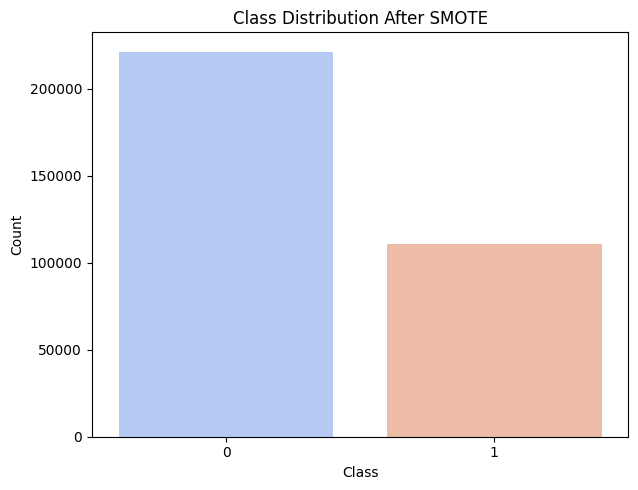

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, palette="coolwarm")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### MODEL TRAINING

Stratified K-Fold Sampling


In [10]:
#Apply stratified K-fold sampling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]


In [11]:
# Cost-sensitive learning
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

##### Initializing the XGBoost Model

In [20]:
# XGBoost with regularization and early stopping
model = XGBClassifier(
objective="binary:logistic",
scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
max_depth=5,
learning_rate=0.05,
n_estimators=200,
reg_alpha=0.1,  # L1 regularization
reg_lambda=0.2,  # L2 regularization
early_stopping_rounds=10,
eval_metric="logloss",
random_state=42
)

In [22]:
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

##### Classification Report

In [23]:
# Predictions
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87     44243
           1       0.70      0.86      0.77     22122

    accuracy                           0.83     66365
   macro avg       0.81      0.84      0.82     66365
weighted avg       0.85      0.83      0.84     66365



##### Understanding Feature Contribution usinf SHAP

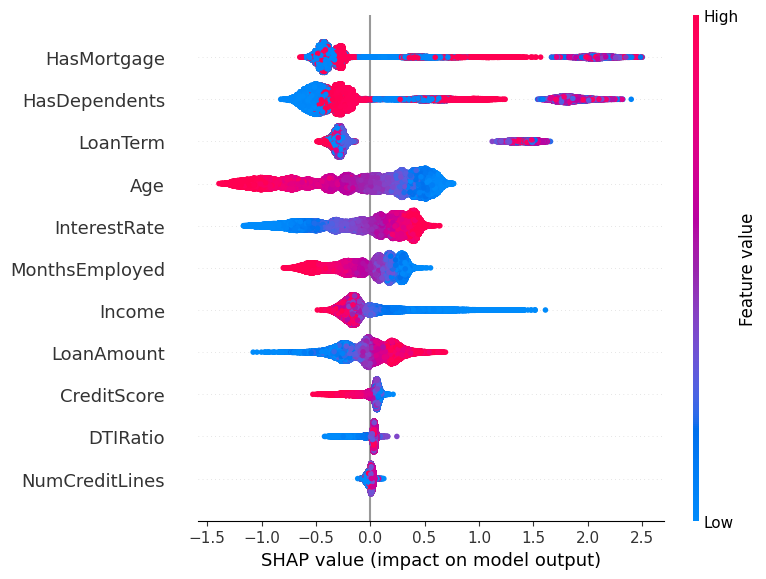

In [24]:
# Interpretability using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

##### Visualizing Feature Importance Scores

C:\Users\aadit\AppData\Local\Temp\ipykernel_18272\849959178.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="viridis")


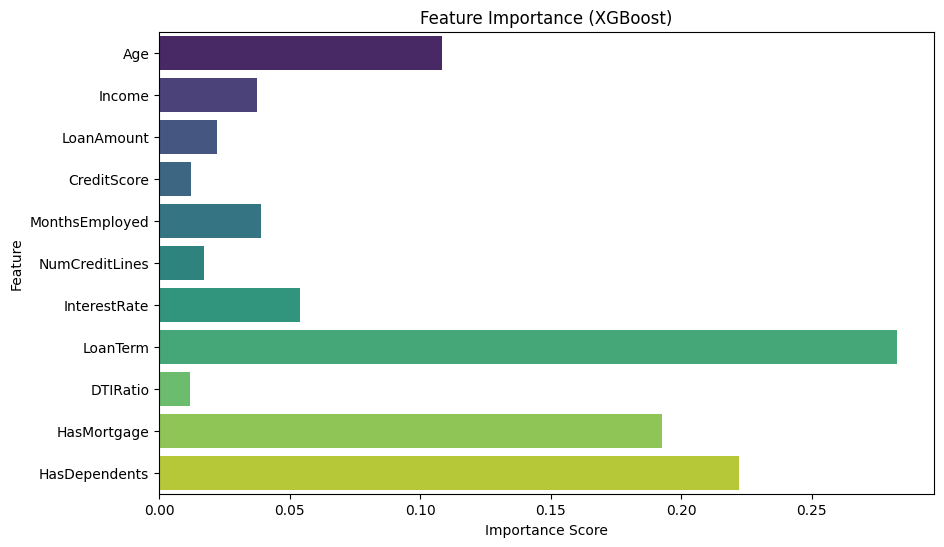

In [25]:
# Feature Importance using XGBoost
plt.figure(figsize=(10, 6))
feature_importances = model.feature_importances_
sns.barplot(x=feature_importances, y=features, palette="viridis")
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

##### Automate Hyperparameter Tuning Using GridSearchCV

In [ ]:
import numpy as np
y_train = np.array(y_train) 


In [27]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#Defining parameter grid 
param_grid = {
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "reg_alpha": [0, 0.1, 0.2, 0.5],
    "reg_lambda": [0.1, 0.2, 0.5, 1.0]
}

#GridSearchCV 
grid_search = GridSearchCV(
    XGBClassifier(random_state=42), param_grid, 
    cv=3, scoring="accuracy", verbose=1, n_jobs=-1
)
grid_search.fit(X_train, y_train)

#Outputing the best params
print("Best Parameters:", grid_search.best_params_)

#Training
best_model = XGBClassifier(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

#Prediction and evaluation
y_pred_best = best_model.predict(X_test)
print("Classification Report (After Hyperparameter Tuning):\n", classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Classification Report (After Hyperparameter Tuning):
               precision    recall  f1-score   support

           0       0.88      0.99      0.94     44243
           1       0.98      0.74      0.84     22122

    accuracy                           0.91     66365
   macro avg       0.93      0.87      0.89     66365
weighted avg       0.92      0.91      0.90     66365

